# Mind Wandering
This notebook documents the mind wandering VR experiment in conjunction with 1) biosignalsplux EEG and fNIRS sensors, and 2) the DSI 24 EEG headset.

## Experiment

The experiment induces and measures mind wandering by having the subject identify misspelled words in a long text. When a subject does not identify a misspelled word, we can say that they are not focused and consider them to be "mind-wandering" at that point in the experiment. The experiment controller uses eye tracking to watch the user's vision, so we can tracke exactly where they are in the text throughout the experiment. 

For the subject, the sequence of the experiment is as follows (the subject is wearing a VR headset with eye tracking enabled):

1. Read the tutorial. The tutorial explains the experiment and the controls.
2. Perform trial run. This is the same as the actual experiment, except it is much shorter and there are no misspelled words. It is just a sandbox for the subject to get used to the reading pace and the controls for marking words as misspelled.
3. Read full text. This is where the bulk of the experiment happens. It takes roughly 20 minutes to get through the full text.
4. Answer questions. There are a couple multiple choice questions at the end of the experiment for the subject to answer. The responses are recorded in a json file.

## Type I and II Errors
$$H_0 \equiv \text{Word is not misspelled}$$
$$H_a \equiv \text{Word is misspelled}$$
The user can make two errors:
- Type I: Marking a correctly spelled word
- Type II: Skipping an incorrectly spelled word

Type II errors signify mind wandering and are thus the primary focus, however type I errors are also discussed.

## Images

Below are two images from the subject's perspective in VR. Note that since the subject is in VR these look slightly warped.

![Reading](assets/reading.jpg "Regular Reading")

*Figure 1: An example of what the user might see during the experiment*

![Misspelled](assets/misspelled.jpg "Misspelled Word")

*Figure 2: The user marked the word "potter" as misspelled*

## Example Data and Processing

Reza performed the mind wandering experiment twice with two different sensor configurations:
1. Plux EEG/fNIRS sensors:
    - Active elctrode: F7 (10-20)
    - Reference: Fp1 (10-20)
    - fNIRS: Fpz (10-5)

2. DSI 24 Headset

In [2]:
import pandas as pd
import numpy as np
import json
import datetime as dt
import biosignalsnotebooks as bsnb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, Markdown
from dateutil import parser

from utils.multitaper_spectogram_python import multitaper_spectrogram

## Experiment 1: Plux EEG
This run used a single channel EEG on the F7 electrode. The fNIRS data is collected but not analyzed in this document.

In [3]:
plux_filepath = "reza_mind_wandering.txt"
plux_vr_filepath = "mind-wandering-152412.csv"
plux_questions_filepath = "mind-wandering-152412-questions.json"


In [4]:
# LOAD PLUX DATA
with open(plux_filepath) as plux:
    header = json.loads(plux.readlines()[1][1:])
    
    key = list(header.keys())[0]
    #plux_start = header.get
    #print(json.dumps(header[key], indent=4))
    plux_date = header[key]["date"]
    plux_time = header[key]["time"]

    plux_start = dt.datetime.strptime(plux_date + " " + plux_time, "%Y-%m-%d %H:%M:%S.%f")
   

    plux_sampling_rate = header[key]["sampling rate"]
    plux_resolution = header[key]["resolution"][0]

    plux_columns = header[key]["column"]
    #print(plux_columns)

    #print(plux_sampling_rate, plux_start)

plux_raw = np.loadtxt(plux_filepath, skiprows=3)
plux_data = pd.DataFrame(plux_raw, columns=plux_columns)
plux_data["time"] = plux_data["nSeq"].apply(lambda t: plux_start + dt.timedelta(seconds=t/plux_sampling_rate))

display(Markdown("### Plux Data"))
display(plux_data)


### Plux Data

,nSeq,DI,CH1,CH9A,CH9B,time
0,0.0,0.0,30760.0,0.0,0.0,2021-12-15 15:00:34.949
1,1.0,0.0,29304.0,0.0,0.0,2021-12-15 15:00:34.950
2,2.0,0.0,28484.0,4527.0,134380.0,2021-12-15 15:00:34.951
3,3.0,0.0,28800.0,4527.0,134380.0,2021-12-15 15:00:34.952
4,4.0,0.0,28840.0,105060.0,174547.0,2021-12-15 15:00:34.953
...,...,...,...,...,...,...
1445845,1445845.0,0.0,34930.0,97021.0,107321.0,2021-12-15 15:24:40.794
1445846,1445846.0,0.0,27624.0,96891.0,107291.0,2021-12-15 15:24:40.795
1445847,1445847.0,0.0,16112.0,96891.0,107291.0,2021-12-15 15:24:40.796
1445848,1445848.0,0.0,7238.0,97911.0,107267.0,2021-12-15 15:24:40.797


In [5]:
# LOAD VR DATA
def get_vr_data(filepath):
    vr_data = pd.read_csv(filepath)

    vr_data["time"] = vr_data["Time"].apply(lambda t: parser.parse(t[:-6]))
    vr_data["time"] = pd.to_datetime(vr_data["time"])

    #display(Markdown("## All VR Data"))
    #display(vr_data)

    type_i = vr_data[~vr_data["Misspelled"] & vr_data["Triggered"]]
    type_ii = vr_data[vr_data["Misspelled"] & ~vr_data["Triggered"]]

    display(Markdown(f"**Total VR datapoints:** {vr_data.shape[0]}"))
    display(Markdown(f"**Type I errors:** {type_i.shape[0]}"))
    display(Markdown(f"**Type II errors:** {type_ii.shape[0]}"))

    return vr_data, type_i, type_ii

vr_data, type_i, type_ii = get_vr_data(plux_vr_filepath)

#display(Markdown("## Type I Errors"))
#display(type_i)

#display(Markdown("## Type II Errors"))
#display(type_ii)

**Total VR datapoints:** 3880

**Type I errors:** 29

**Type II errors:** 15

### Plux Spectrogram

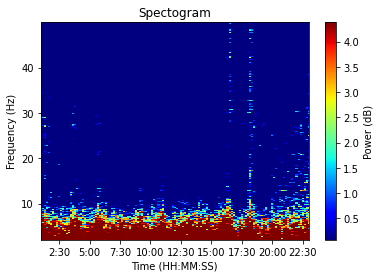

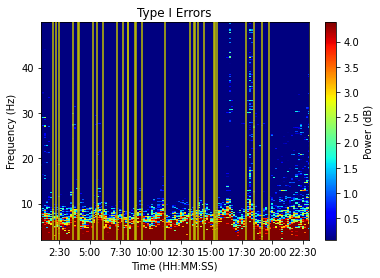

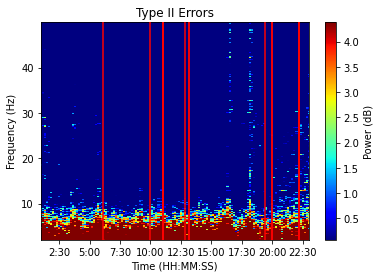

In [6]:
plux_eeg_data = plux_data["CH1"]

plux_eeg_uv = bsnb.raw_to_phy("EEG", "biosignalsplux", plux_eeg_data, plux_resolution, "uV")
plux_time_uv = bsnb.generate_time(plux_eeg_uv, plux_sampling_rate)

type_i_times = []
for idx, i in type_i.iterrows():
    t = (i["time"] - plux_start).total_seconds()
    type_i_times.append(t)

type_ii_times = []
for idx, ii in type_ii.iterrows():
    t = (ii["time"] - plux_start).total_seconds()
    type_ii_times.append(t)

##print(type_i_times)
#print(type_ii_times)
    #print(i["time"] - plux_start)

#plt.title("Spectogram")
display(Markdown("### Plux Spectrogram"))

plt.title("Spectogram")
spect, stimes, sfreqs = multitaper_spectrogram(plux_eeg_uv, plux_sampling_rate, frequency_range=[2, 50], window_params=[120, 10], verbose=False)

plt.title("Type I Errors")
spect, stimes, sfreqs = multitaper_spectrogram(plux_eeg_uv, plux_sampling_rate, frequency_range=[2, 50], window_params=[120, 10], type_i_times=type_i_times, verbose=False)

plt.title("Type II Errors")
spect, stimes, sfreqs = multitaper_spectrogram(plux_eeg_uv, plux_sampling_rate, frequency_range=[2, 50], window_params=[120, 10], type_ii_times=type_ii_times, verbose=False)

In [7]:
def show_survey_questions(filepath):
    with open(filepath) as f:
        questions = json.load(f)

        display(Markdown("### End of Experiment Survey Questions"))

        for q in questions["questions"]:
            display(Markdown(f"**{q['question']}**"))
            display(Markdown(f"*{q['choice']}*"))

show_survey_questions(plux_questions_filepath)

### End of Experiment Survey Questions

**Are you ready to begin?**

*Yes*

**After how many hours the pill lost its effect?**

*2 hours*

**Did you mind wander reading the essay?**

*Yes*

**Approximately, how many times did you mind wander?**

*More than 5 times*

**Was the essay too hard to understand?**

*Yes*

**Did you skip some parts of the text?**

*Yes*

## Experiment 2: DSI 24
The second experiment was run with the DSI 24-channel EEG headset.

In [8]:
dsi_filepath = "reza_mw1_raw.csv"
dsi_vr_filepath = "mind-wandering-184607.csv"
dsi_questions_filepath = "mind-wandering-184607-questions.json"

In [9]:
# LOAD DSI DATA

with open(dsi_filepath) as dsi:
    for i in range(15):
        line = dsi.readline()
        if i == 6:
            dsi_date = dt.datetime.strptime(line, "# Date =,%m/%d/%Y,,,,,,,,,,,,,,,,,,,,,,,,,,,\n")
        if i == 7:
            dsi_time = dt.datetime.strptime(line, "# Time =, %H:%M:%S.%f ,,,,,,,,,,,,,,,,,,,,,,,,,,,\n")
            #print(dsi_date)
            #print(dsi_time)
    dsi_start = dt.datetime.combine(dsi_date, dsi_time.time())
    #display(Markdown(f"DSI Start time: {dsi_start}"))
    dsi_data = pd.read_csv(dsi)

    dsi_data["time"] = dsi_data["Time"].apply(lambda t: dsi_start + dt.timedelta(seconds=t))
    display(Markdown("### DSI Data"))
    display(dsi_data)
       

### DSI Data

,Time,P3,C3,F3,Fz,F4,C4,P4,Cz,CM,...,A2,T6,T4,Trigger,Time_Offset,ADC_Status,ADC_Sequence,Event,Comments,time
0,0.0033,-1027.8,82.5,68.4,-467.1,-271.2,-351.9,-586.5,126.3,-3112.2,...,121.5,-7.8,-263.4,0,6,0,221,0,,2021-12-31 18:26:02.138300
1,0.0067,-1025.1,84.9,73.8,-462.3,-262.5,-340.5,-582.3,129.9,-3112.2,...,144.3,0.3,-255.3,0,12,0,222,0,,2021-12-31 18:26:02.141700
2,0.0100,-1017.3,89.4,80.4,-452.4,-255.6,-336.3,-575.1,131.4,-3038.1,...,144.3,3.9,-252.0,0,18,0,223,0,,2021-12-31 18:26:02.145000
3,0.0133,-1015.8,87.6,78.9,-453.0,-258.9,-336.9,-579.3,130.2,-2815.8,...,143.1,7.5,-250.2,0,24,0,224,0,,2021-12-31 18:26:02.148300
4,0.0167,-1021.5,76.5,72.9,-451.5,-258.9,-342.6,-585.0,123.0,-3038.1,...,133.8,-2.4,-256.8,0,30,0,225,0,,2021-12-31 18:26:02.151700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367827,1226.0917,3.0,318.9,153.3,70.8,125.4,79.8,109.5,51.9,-1704.3,...,222.9,123.9,55.5,0,2206965,0,176,0,,2021-12-31 18:46:28.226700
367828,1226.0950,3.3,316.2,145.8,69.6,121.2,79.5,108.0,49.8,-1852.5,...,222.3,116.7,44.1,0,2206971,0,177,0,,2021-12-31 18:46:28.230000
367829,1226.0983,3.3,313.5,148.2,65.7,119.1,77.4,106.5,51.0,-1704.3,...,218.4,124.2,49.2,0,2206977,0,178,0,,2021-12-31 18:46:28.233300
367830,1226.1017,3.3,314.7,142.5,61.8,119.7,79.2,105.6,47.4,-1926.6,...,219.6,124.8,43.5,0,2206983,0,179,0,,2021-12-31 18:46:28.236700


In [10]:
vr_data, type_i, type_ii = get_vr_data(dsi_vr_filepath)


**Total VR datapoints:** 3676

**Type I errors:** 22

**Type II errors:** 11

### DSI Spectrogram *(F7 only)*

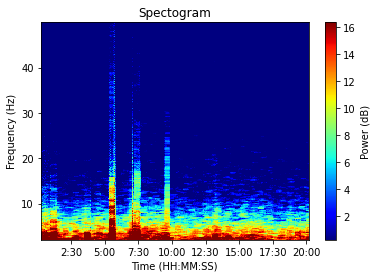

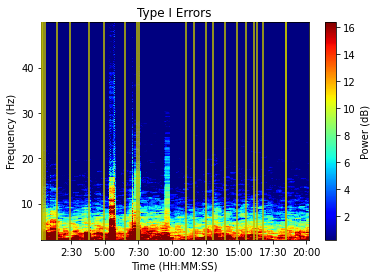

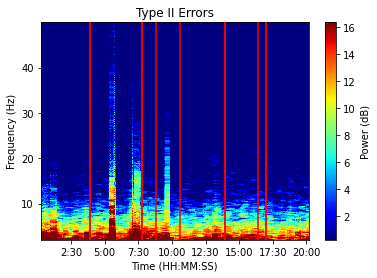

In [11]:
dsi_f7_data = dsi_data["F7"].to_numpy()
dsi_sampling_rate = 300 

#plux_time_uv = bsnb.generate_time(plux_eeg_uv, plux_sampling_rate)

type_i_times = []
for idx, i in type_i.iterrows():
    t = (i["time"] - dsi_start).total_seconds()
    type_i_times.append(t)

type_ii_times = []
for idx, ii in type_ii.iterrows():
    t = (ii["time"] - dsi_start).total_seconds()
    type_ii_times.append(t)

##print(type_i_times)
#print(type_ii_times)
    #print(i["time"] - plux_start)

#plt.title("Spectogram")

display(Markdown("### DSI Spectrogram *(F7 only)*"))

plt.title("Spectogram")
spect, stimes, sfreqs = multitaper_spectrogram(dsi_f7_data, dsi_sampling_rate, frequency_range=[2, 50], window_params=[30, 5], verbose=False)

plt.title("Type I Errors")
spect, stimes, sfreqs = multitaper_spectrogram(dsi_f7_data, dsi_sampling_rate, frequency_range=[2, 50], window_params=[30, 5], type_i_times=type_i_times, verbose=False)

plt.title("Type II Errors")
spect, stimes, sfreqs = multitaper_spectrogram(dsi_f7_data, dsi_sampling_rate, frequency_range=[2, 50], window_params=[30, 5], type_ii_times=type_ii_times, verbose=False)

#show_survey_questions(dsi_questions_filepath)

## Exporting DSI / VR Synchronized Data
*This section is mostly for Ken's work and is unrelated to the rest of the notebook*

The DSI Data is synchronized with the type II events and exported as two files for analysis. The "time" column is what is the same between them

In [15]:
dsi_data = dsi_data.drop(columns="time")
dsi_data.to_csv("mind_wandering_dsi.csv", index=False)

type_ii["Time"] = type_ii["time"].apply(lambda t: (t - dsi_start).total_seconds())
type_ii = type_ii.drop(columns="time")
display(type_ii)
type_ii.to_csv("mind_wandering_events.csv", index=False)

C:\Users\jhsul\AppData\Local\Temp/ipykernel_4356/678352373.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_ii["Time"] = type_ii["time"].apply(lambda t: (t - dsi_start).total_seconds())


,Time,Section,Index,Line,Word,Misspelled,Triggered
666,232.814122,1,147,17,doshmanxy,True,False
669,233.395122,1,147,17,doshmanxy,True,False
1373,467.279703,1,643,81,pretconfexz,True,False
1376,468.229798,1,643,81,pretconfexz,True,False
1587,528.982329,1,773,98,emonfulxx,True,False
1942,634.314331,1,1001,127,zxembling,True,False
2589,834.991493,1,1438,183,xyztgb,True,False
2591,836.455492,1,1438,183,xyztgb,True,False
3085,984.231101,1,1762,224,grashxyzli.,True,False
3195,1018.991986,1,1839,233,xpyonenk,True,False
